In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import data_plot_functions as dp
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator, LogLocator, MultipleLocator, FuncFormatter

import lmfit
from lmfit import Parameters, minimize, fit_report

%matplotlib inline

# Load the CSV files
file1 = "./input_data/hatzi_gp.csv"  # Replace with the actual file path
file2 = "./input_data/hatzi_gpp.csv"  # Replace with the actual file path
output_file = "./output_data/"

# Read the first two columns
df1 = pd.read_csv(file1, usecols=[0, 1], header=None, names=["X1", "Y1"])
df2 = pd.read_csv(file2, usecols=[0, 1], header=None, names=["X2", "Y2"])

# Extract values
X1, Y1 = df1["X1"].values, df1["Y1"].values
X2, Y2 = df2["X2"].values, df2["Y2"].values

Y1 = Y1 * 1E+6
Y2 = Y2 * 1E+6

interp_func = interp1d(np.log(X1), np.log(Y1), kind="linear", fill_value="extrapolate")
Y1_interpolated = np.exp(interp_func(np.log(X1)))

interp_func = interp1d(np.log(X2), np.log(Y2), kind="linear", fill_value="extrapolate")
Y2_interpolated = np.exp(interp_func(np.log(X1)))

tau_min_values = [1.8E-5]

time = np.logspace(-9, 7, 100)
tau = np.logspace(np.log10(tau_min_values[0]), +8, num=1000, base=10)
omega = np.logspace(-8, 8, 100)

## Generating spectrum and moduli using the mBSW spectrum given below

$$ H(\tau) = e^{-\left(\frac{\tau}{\tau_{\text{max}}}\right)^{\beta}} \left[ H_e \left(\frac{\tau}{\tau_{\text{max}}}\right)^{n_e} + H_g \left(\frac{\tau}{\tau_e}\right)^{-n_g} \right] $$

In [29]:
def compute_rheological_properties(tau, time, omega, bsw_params, at1=1, at2=1):
    r"""
    Compute relaxation modulus (g_relax), storage modulus (gp_model), and loss modulus (gpp_model)
    given tau, time, omega, and BSW parameters.

    The relaxation spectrum \( H(\tau) \) is given by:

    .. math::
        H(\tau) = e^{-\left(\frac{\tau}{\tau_{\text{max}}}\right)^{\beta}}
        \left[ H_e \left(\frac{\tau}{\tau_{\text{max}}}\right)^{n_e} + 
        H_g \left(\frac{\tau}{\tau_e}\right)^{-n_g} \right]

    Parameters:
    - tau: array of relaxation times
    - time: array of time values
    - omega: array of angular frequencies
    - bsw_params: list of BSW model parameters
    - at1, at2: shift factors for \(\tau_e\) and \(\tau_{\text{max}}\)

    Returns:
    - g_relax: Relaxation modulus array
    - gp_model: Storage modulus array
    - gpp_model: Loss modulus array
    - omega: Angular frequency array (for plotting)
    - time: Time array (for plotting)
    """

    # Compute shifted tau values
    tau_e_shifted = bsw_params[2] * at1
    tau_max_shifted = bsw_params[5] * at1

    # Compute flow contribution
    htau_flow = np.exp(-(np.power(tau / tau_max_shifted, bsw_params[6]))) * \
                (bsw_params[3] * np.power(tau / tau_max_shifted, bsw_params[4]))

    # Compute glassy contribution
    tau_e_shifted = bsw_params[2] * at2
    tau_max_shifted = bsw_params[5] * at2

    htau_glassy = np.exp(-(np.power(tau / tau_max_shifted, bsw_params[6]))) * \
                  (bsw_params[0] * (np.power(tau / tau_e_shifted, -bsw_params[1])))

    # Total relaxation spectrum
    htau_total = htau_flow + htau_glassy
    # gi = htau_total / tau

    q_weights = np.zeros_like(tau)
    q_weights[0]    = 0.5 * np.log(tau[1]/tau[0])
    q_weights[-1]   = 0.5 * np.log(tau[-1]/tau[-2])
    q_weights[1:-1] = 0.5 * (np.log(tau[2:]) - np.log(tau[0:-2]))

    # Compute relaxation modulus g_relax
    tau_time = -time[:, np.newaxis] / tau[np.newaxis, :]
    g_tau_time = np.exp(tau_time) * htau_total
    # g_relax = np.sum(np.diff(tau) * (g_tau_time[:, :-1] + g_tau_time[:, 1:]) / 2, axis=1)
    g_relax = np.sum((q_weights * g_tau_time), axis=1)

    # Compute storage modulus (Gp) and loss modulus (Gpp)
    tau_omega = omega[:, np.newaxis] * tau[np.newaxis, :]
    inv_plus_squared = 1 / (1 + tau_omega**2)

    gp_tau_omega = (tau_omega**2) * inv_plus_squared * htau_total
    gpp_tau_omega = (tau_omega**1) * inv_plus_squared * htau_total

    # gp_model = np.sum(np.diff(tau) * (gp_tau_omega[:, :-1] + gp_tau_omega[:, 1:]) / 2, axis=1)
    # gpp_model = np.sum(np.diff(tau) * (gpp_tau_omega[:, :-1] + gpp_tau_omega[:, 1:]) / 2, axis=1)

    gp_model = np.sum((q_weights * gp_tau_omega), axis=1)
    gpp_model = np.sum((q_weights * gpp_tau_omega), axis=1)
    
    return htau_total, g_relax, gp_model, gpp_model, time, omega

### Fitting code
Can be commented out but remove bsw params from the loop later on

In [30]:
def residual_fcn(params, omega, gp_exp, gpp_exp, tau, time):
    
    full_params = np.array([params[p].value for p in params])
    htau, g_relax, gp_model, gpp_model, time, omega = compute_rheological_properties(tau, time, omega, full_params)
    
    nan_locations = np.isnan(gp_model)
    nan_indices = np.where(nan_locations)[0]
    if np.any(nan_locations):
        print(f"nan found in {gp_model} at freq in {omega[nan_indices]} with the params {params}")
    
    resid_gp = ((gp_exp - gp_model) / ((gp_exp + 1E-8)))
    resid_gpp = ((gpp_exp - gpp_model) / ((gpp_exp + 1E-8)))
    
    return np.hstack((resid_gp, resid_gpp)).flatten()

fit_params = Parameters()

fit_params.add(f"Hg",       value=5.0E+5,   vary=True,      min=5.0E+3,     max=5.0E+6)
fit_params.add(f"ng",       value=0.67,     vary=True,      min=0.0,        max=1.0)
fit_params.add(f"tau_e",    value=0.86,     vary=True,      min=0.0,        max=100.0)
fit_params.add(f"He",       value=2.0E+5,   vary=True,      min=5.0E+4,     max=5.0E+6)
fit_params.add(f"ne",       value=0.3,      vary=True,      min=0.0,        max=1.0)
fit_params.add(f"tau_max",  value=9.0E+5,   vary=True,      min=5.0E+4,     max=5.0E+6)
fit_params.add(f"beta",     value=2.0E-0,   vary=False,      min=0.0,        max=5.0)

minimizer = lmfit.Minimizer(
                                residual_fcn, fit_params, 
                                fcn_args=(
                                        X1, Y1_interpolated, Y2_interpolated, tau, time,
                                        )
                                )

out = minimizer.minimize(
                                method="leastsq",
                                params=fit_params,
                                ftol=1e-12,         
                                xtol=1e-12,         
                                gtol=1e-12,         
                                max_nfev=10000,     
                            )

bsw_params = np.array([out.params[name].value for name in out.params])

In [31]:
print(bsw_params)

[1.03808796e+06 7.59433741e-01 5.14135918e-02 3.37720401e+05
 3.45659638e-01 9.40814667e+05 2.00000000e+00]


### MAIN - Calculating the spectrum and plotting

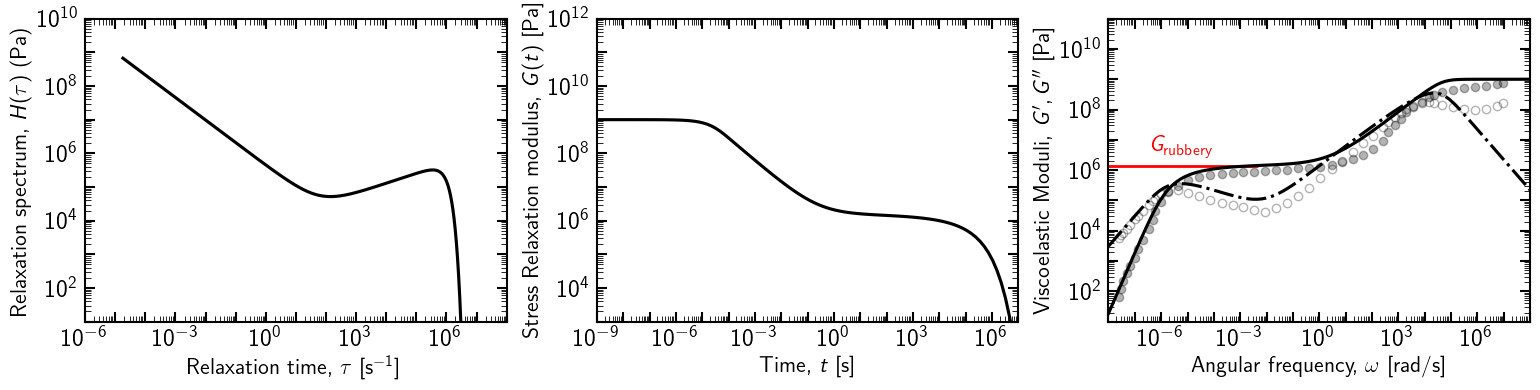

In [43]:
paper_bsw_params = [
    4.9E+5,  # Hg
    6.7E-1,  # n_g
    8.6E-1,  # tau_e
    4.95E+5, # He
    3.0E-1,  # n_e
    9.0E+5,  # tau_max
    2.0E+0   # beta
]

colors = ['k', 'r', 'g', 'b']
# labels = [rf"$10^{{{int(np.log10(val))}}}$" for val in tau_min_values]
labels = ["Hatzikirikos", "New fit"]

fig, axes, *_ = dp.set_plot_params(num_plots=3)
axes[2].loglog(X1, Y1_interpolated, label="Exp data", marker="o", linestyle=" ", 
               markersize=6, markerfacecolor='black', markeredgecolor='black', alpha=0.3)
axes[2].loglog(X1, Y2_interpolated, marker="o", linestyle=" ", 
               markersize=6, markerfacecolor='none', markeredgecolor='black', alpha=0.3) 

for i, tau_min in enumerate(tau_min_values):
    for j, params in enumerate([paper_bsw_params]): # if the section was commented out earlier, change the list HERE
        
        tau = np.logspace(np.log10(tau_min), +8, num=1000, base=10)
        htau, g_relax, gp_model, gpp_model, time, omega = compute_rheological_properties(tau, time, omega, params)
        
        mask = (omega > 1E-4) & (omega < 1E-1)
        rm_index = np.argmin(gpp_model[mask])
        original_index = np.where(mask)[0][rm_index]
        
        if j == 0: # control which params are being output
            dynamic_moduli_df = pd.DataFrame({"Angular frequency": omega, "Storage modulus": gp_model, "Loss modulus": gpp_model})
            relaxation_df = pd.DataFrame({"Time": time, "Relaxation modulus": g_relax})
            spectrum_df = pd.DataFrame({"Tau": tau, "Spectrum modulus (htau)": htau})
            
            dynamic_moduli_df.to_csv(output_file + 'model_dynamic_moduli.csv', index=False)
            relaxation_df.to_csv(output_file + 'model_relaxation.csv', index=False)
            spectrum_df.to_csv(output_file + 'model_spectrum.csv', index=False)
        
        axes[0].plot(tau, htau, linestyle="-", color=colors[i+j], label=labels[i+j])
        
    
        axes[2].hlines(y=gp_model[original_index], xmin=1E-8, xmax=omega[original_index], colors='red', linestyles='-', linewidth=2)
        axes[2].text((1E-8 * omega[original_index]) ** 0.5, 1.8*gp_model[original_index], "$G_{\\text{rubbery}}$", 
        fontsize=16, color='red', ha='center', va='bottom', backgroundcolor="white")

        # axes[0].loglog(tau, htau/tau, linestyle="-", color='k', label=labels[j])
        axes[1].plot(time, g_relax, linestyle="-", color=colors[i+j], label=labels[i+j])
        axes[2].plot(omega, gp_model, linestyle="-", color=colors[i+j], label=labels[i+j])
        axes[2].plot(omega, gpp_model, linestyle="-.", color=colors[i+j])

# region PLOT SETTINGS
axes[0].set_xlim([1E-6, 1E+8])
axes[0].set_ylim([1E+1, 1E+10])

axes[1].set_xlim([1E-9, 1E+7])
axes[1].set_ylim([1E+3, 1E+12])

axes[2].set_xlim([1E-8, 1E+8])
axes[2].set_ylim([1E+1, 1E+11])

axes[0].set_xlabel("Relaxation time, $\\tau$ [s$^{-1}$]")
axes[0].set_ylabel("Relaxation spectrum, $H(\\tau)$ (Pa)")
# axes[0].legend(title=r"$\tau_{\min}$", fontsize=12, title_fontsize=14)

axes[1].set_xlabel(dp.rheology_labels["Time"])
axes[1].set_ylabel(dp.rheology_labels["Relaxation modulus"])
# axes[1].legend(title=r"$\tau_{\min}$", fontsize=12, title_fontsize=14)

axes[2].set_xlabel(dp.rheology_labels["Angular frequency"])
axes[2].set_ylabel(dp.rheology_labels["Loss modulus"])
# axes[2].legend(title=r"$\tau_{\min}$", fontsize=12, title_fontsize=14)

yexponents_to_label = np.arange(-12, 16, 2)  # Change step to 3 for every 3 decades
xexponents_to_label = np.arange(-12, 18, 3) 

# Define the custom labeling function
def xcustom_labeling(val, pos):
    """ Show labels only for predefined exponents. """
    if val <= 0:
        return ""
    exponent = np.log10(val)
    if exponent in xexponents_to_label:
        return rf"$10^{{{int(exponent)}}}$"
    else:
        return ""  # Hide other labels
def ycustom_labeling(val, pos):
    """ Show labels only for predefined exponents. """
    if val <= 0:
        return ""
    exponent = np.log10(val)
    if exponent in yexponents_to_label:
        return rf"$10^{{{int(exponent)}}}$"
    else:
        return ""  # Hide other labels
    
plt.rcParams['xtick.labelsize'] = 6  # Reduce x-axis tick label size
plt.rcParams['ytick.labelsize'] = 6 

for ax in axes:
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=[1.0], numticks=20))
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=[1.0], numticks=100))

    ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100))
    ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100))
    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(xcustom_labeling))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(ycustom_labeling))

plt.tight_layout()
plt.show()
# endregion 